# Plot WER

## Imports

In [27]:
import pathlib
import re
from dataclasses import dataclass
import matplotlib.pyplot as plt
from typing import List, Optional, Dict
import numpy as np

## General & constants

In [28]:
HOME_PATH = pathlib.Path.home()
EXPERIMENTS_PATH = HOME_PATH.joinpath("experiments")

experiments_used = {
    "AED": EXPERIMENTS_PATH.joinpath("25_09_08_demo1_sllm"),
    "SLLM": EXPERIMENTS_PATH.joinpath("25_10_17_sllm_d2"),
}

V2000_EPOCHS_4_GPUS = 500

n_epochs_per_exp = {
    "v2": V2000_EPOCHS_4_GPUS,
    "v3": V2000_EPOCHS_4_GPUS,
    "SLLM_small_decoder_4gpus_i6_v2": V2000_EPOCHS_4_GPUS,
    "SLLM_small_decoder_4gpus_i6": V2000_EPOCHS_4_GPUS,
}


def get_results_path_of_experiment(experiment_path: pathlib.Path) -> pathlib.Path:
    return experiment_path.joinpath("output", "experiments")


_NUMERIC_DIR_PATTERN = re.compile(r"^\d+$")


def is_experiment_version_root(path: pathlib.Path) -> bool:
    """
    An experiment-version root is a directory that contains *at least one*
    numeric subdirectory such as "160", "320", etc.
    """
    if not path.is_dir():
        return False

    for child in path.iterdir():
        if child.is_dir() and _NUMERIC_DIR_PATTERN.match(child.name):
            return True

    return False


def get_experiment_version_paths(experiment_path: pathlib.Path) -> List[pathlib.Path]:
    exp_output_path = get_results_path_of_experiment(experiment_path)

    experiment_version_paths = []

    # BFS or DFS both fine; DFS is simpler
    stack = [exp_output_path]

    while stack:
        current = stack.pop()

        # Check if current is a valid version root
        if is_experiment_version_root(current):
            experiment_version_paths.append(current)
            # DO NOT recurse below this level: inner numeric dirs are epochs
            continue

        # Otherwise recurse into subdirectories
        for child in current.iterdir():
            if child.is_dir():
                stack.append(child)

    return experiment_version_paths


## Data

In [29]:
@dataclass
class ExperimentVersionResults:
    exp_version_name: str
    exp_version_path: pathlib.Path
    wer_per_epoch_per_eval: dict[str, list[tuple[int, float]]]
    wer_per_best_per_eval: dict[str, list[tuple[str, float]]]
    total_epochs: int = 2000

    def get_max_epoch(self) -> int:
        """
        Get larger epoch.
        """
        max_epoch: int = -1
        for dataset, values_per_epoch in  self.wer_per_epoch_per_eval.items():
            for (epoch, wer) in values_per_epoch:
                if epoch > max_epoch:
                    max_epoch = epoch
        if max_epoch == -1:
            raise Exception("No epochs stored!")
        return max_epoch

    def get_training_progress(self) -> float:
        """
        Get larger epoch.
        """
        return self.get_max_epoch() / self.total_epochs


@dataclass
class ExperimentResults:
    exp_id: str
    exp_path: pathlib.Path
    exp_version_results: list[ExperimentVersionResults]

    def get_version_names(self) -> List[str]:
        return [exp_ver.exp_version_name for exp_ver in self.exp_version_results]


def read_wer_file(path: pathlib.Path) -> float:
    text = path.read_text().strip()
    return float(text)


def parse_experiment_version(version_path: pathlib.Path, multiple_lm_corrections) -> ExperimentVersionResults:
    version_name = version_path.name

    # We will collect: dataset_name -> [(step, wer_value)]
    wer_per_epoch_per_dataset = {}
    wer_per_best_per_dataset = {}

    # Traverse search configs
    for epoch in version_path.iterdir():
        if not epoch.is_dir():
            continue

        epoch_dir = _NUMERIC_DIR_PATTERN.match(epoch.name)

        # Traverse all datasets inside search config
        for dir in epoch.iterdir():
            if not dir.is_dir():
                continue

            test_wer_file = dir.joinpath("sclite", "wer")
            if test_wer_file.exists(): # Test-clean and test-other
                test_wer_value = read_wer_file(test_wer_file)
                if epoch_dir:
                    wer_per_epoch_per_dataset.setdefault(dir.name, []).append((int(epoch.name), test_wer_value))
                else:
                    wer_per_best_per_dataset.setdefault(dir.name, []).append((epoch.name, test_wer_value))
            else: # Devs
                dev_name = dir.name
                for dev_dir in dir.iterdir():
                    if not dev_dir.is_dir():
                        continue

                    dev_wer_file = dev_dir.joinpath("sclite", "wer")
                    if dev_wer_file.exists(): # dev-clean and dev-other
                        dev_wer_value = read_wer_file(dev_wer_file)

                        if multiple_lm_corrections:
                            dataset_name = f"{dev_name}-{dev_dir.name}"
                        else:
                            dataset_name = dev_dir.name

                        if epoch_dir:
                            wer_per_epoch_per_dataset.setdefault(dataset_name, []).append((int(epoch.name), dev_wer_value))
                        else:
                            wer_per_best_per_dataset.setdefault(dataset_name, []).append((epoch.name, dev_wer_value))

    return ExperimentVersionResults(
        exp_version_name=version_name,
        exp_version_path=version_path,
        wer_per_epoch_per_eval=wer_per_epoch_per_dataset,
        wer_per_best_per_eval=wer_per_best_per_dataset
    )


def load_all_experiment_results(exps_dict: dict[str, pathlib.Path], multiple_lm_corrections:bool = False) -> List[ExperimentResults]:
    all_results = []

    for exp_id, exp_path in exps_dict.items():
        print(f"Getting results for experiment {exp_id} ({exp_path})")

        # Use your helper to get all experiment version paths
        version_paths = get_experiment_version_paths(exp_path)

        version_results = [
            parse_experiment_version(version_path, multiple_lm_corrections)
            for version_path in version_paths
        ]

        for version_result in version_results:
            if version_result.exp_version_name in n_epochs_per_exp.keys():
                version_result.total_epochs = n_epochs_per_exp[version_result.exp_version_name]


        exp_results = ExperimentResults(
            exp_id=exp_id,
            exp_path=exp_path,
            exp_version_results=version_results
        )

        all_results.append(exp_results)

    return all_results

experiment_results_list = load_all_experiment_results(experiments_used,
                                                      multiple_lm_corrections=False)

Getting results for experiment AED (/u/marti.juanola/experiments/25_09_08_demo1_sllm)
Getting results for experiment SLLM (/u/marti.juanola/experiments/25_10_17_sllm_d2)


In [30]:
print(experiment_results_list)

[ExperimentResults(exp_id='AED', exp_path=PosixPath('/u/marti.juanola/experiments/25_09_08_demo1_sllm'), exp_version_results=[ExperimentVersionResults(exp_version_name='v2', exp_version_path=PosixPath('/u/marti.juanola/experiments/25_09_08_demo1_sllm/output/experiments/librispeech/aed/ls960/baselines/pytorch_networks.conformer_aed_v1/v2'), wer_per_epoch_per_eval={'dev-other': [(20, 47.49), (160, 10.97), (40, 20.73), (80, 14.37), (320, 7.46), (500, 5.44)], 'dev-clean': [(20, 35.56), (160, 4.94), (40, 10.51), (80, 6.72), (320, 3.15), (500, 2.26)], 'test-other': [(20, 51.37), (160, 11.26), (40, 21.54), (80, 15.14), (320, 7.93), (500, 5.57)], 'test-clean': [(20, 36.05), (160, 4.78), (40, 10.85), (80, 6.66), (320, 3.26), (500, 2.42)]}, wer_per_best_per_eval={'test-clean': [('best', 2.45), ('best4', 2.44), ('500_old', 2.42)], 'test-other': [('best', 5.62), ('best4', 5.6), ('500_old', 5.57)], 'dev-other': [('best', 5.43), ('best4', 5.45), ('500_old', 5.44)], 'dev-clean': [('best', 2.27), ('be

## Plot WER methods

In [31]:
def _include_experiment_version(name: str,
                                include: Optional[List[str]],
                                exclude: Optional[List[str]]) -> bool:
    if include:
        return name in include
    if exclude:
        return name not in exclude
    return True


def _normalize_epochs(wer_list: list[tuple[str, float]], total_epochs: int) -> list[tuple[float, float]]:
    """
    Convert ('500', 5.57) into (500/total_epochs, 5.57)
    and return in ascending epoch order.
    """
    normalized = []
    for epoch_str, wer in wer_list:
        epoch = int(epoch_str)
        norm = epoch / float(total_epochs) * 100
        normalized.append((norm, wer))

    # Sort by normalized epoch value
    normalized.sort(key=lambda x: x[0])
    return normalized

def get_versions_to_plot(experiments: List[ExperimentResults], include_versions: Optional[List[str]], exclude_versions: Optional[List[str]]) -> List[ExperimentVersionResults]:
    versions = []

    # Get only included versions, in that order!
    if include_versions and include_versions != []:
        for ver_name in include_versions:
            for exp in experiments:
                for version in exp.exp_version_results:
                    if version.exp_version_name == ver_name:
                        versions.append(version)
        return versions

    # Get non-excluded versions
    if not exclude_versions:
        exclude_versions = []
    for exp in experiments:
        for version in exp.exp_version_results:
            if not version.exp_version_name in exclude_versions:
                versions.append(version)
    return versions


def _plot_global(experiments: List[ExperimentResults],
                 include_versions: Optional[List[str]],
                 exclude_versions: Optional[List[str]],
                 dataset: str,
                 title: str,
                 y_log: bool = False,
                 ylim_max: Optional[float] = None,
                 name_mappings: Optional[dict[str, str]] = None,
                 show_best_epoch: bool = True,
                 epochs: int = 100) -> None:
    """
    Produce a figure for ALL experiments together.
    """
    if name_mappings is None:
        name_mappings = {}

    plt.figure(figsize=(10, 6), facecolor="white")
    plt.title(f"{title} [{dataset}]")
    plt.xlabel(f"Training Progress Percentage ({epochs} epochs)") # TODO: train steps hardcoded!
    plt.ylabel("WER (%)")

    plotted_any = False

    if y_log:
        plt.yscale("log")

        ax = plt.gca()

        # Set ticks appropriate for your data range (0.9 to 11)
        ticks = [1, 2, 3, 5, 10, 20, 30, 40, 50, 75, 100]
        plt.yticks(ticks, [str(t) for t in ticks])

        # Add minor ticks for the grid
        #ax.yaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(2, 10), numticks=100))
        #ax.yaxis.set_minor_formatter(NullFormatter())

        plt.ylabel("WER % (log scale)")
    else:
        plt.ylabel("WER %")

    if ylim_max is not None:
        plt.ylim(0, ylim_max)
        #plt.ylabel(f"WER % (ylim={ylim_max:.1f})")

    versions_to_plot = get_versions_to_plot(experiments, include_versions, exclude_versions)

    for version in versions_to_plot:
        if dataset not in version.wer_per_epoch_per_eval:
            continue

        wer_list = version.wer_per_epoch_per_eval[dataset]
        if not wer_list:
            continue

        total_epochs = version.total_epochs
        values = _normalize_epochs(wer_list, total_epochs)

        xs = [x for x, _ in values]
        ys = [y for _, y in values]

        if version.exp_version_name in name_mappings.keys():
            label = f"{name_mappings[version.exp_version_name]}"
        else:
            label = f"{exp.exp_id}-{version.exp_version_name}"

        if show_best_epoch:
            label += f" [{round(ys[-1],1):.1f}]"

        plt.plot(
            xs, ys,
            marker='o',
            markersize=4,
            alpha=0.9,
            label=label
        )
        plotted_any = True

    if plotted_any:
        plt.legend()
    else:
        plt.text(0.5, 0.5, "No matching experiment versions", ha='center')

    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()


def plot_experiments(
        experiments: List[ExperimentResults],
        include_versions: Optional[List[str]] = None,
        exclude_versions: Optional[List[str]] = None,
        datasets_to_plot: Optional[List[str]] = None,
        title: str = "",
        y_log: bool = False,
        ylim_max: Optional[float] = 30,
        name_mappings: Optional[Dict[str, str]] = None,
        show_best_epoch: bool = True,
):
    """
    Main API.
    - experiments: list[ExperimentResults]
    - include_versions: optional list[str]
    - exclude_versions: optional list[str]
    - datasets_to_plot: optional list[str], default ['test-clean']
    """
    if datasets_to_plot is None:
        datasets_to_plot = ["dev-other"]
    if exclude_versions is None:
        exclude_versions = ["v3", "bs15000", "v1-Qwen2-0_5B-dropout-15k"]

    for dataset in datasets_to_plot:
        _plot_global(experiments, include_versions, exclude_versions, dataset, title, y_log, ylim_max, name_mappings, show_best_epoch)


## Plotting

In [32]:
for exp in experiment_results_list:
    print(f"Experiment {exp.exp_id}:")
    for v in exp.get_version_names():
        print(f"\t{v}")

# TODO: don't trust bs15000 (could be dropout or not..)

Experiment AED:
	v2
	v3
Experiment SLLM:
	baseline
	SLLM_tuned_dropout
	v1-Qwen2-0_5B
	SLLM_small_decoder_150kBS
	SLLM_small_decoder_250kBS
	SLLM_small_decoder_4gpus_i6
	SLLM_small_decoder_4gpus_i6_v2
	bs30000
	v1-Qwen2-0_5B-dropout-15k
	bs15000
	SLLM_td_lrv2
	SLLM_dropout_s2
	SLLM_td_lrv3
	SLLM_tuned_dropout_v2
	SLLM_linear_adapter
	SLLM_small_decoder


## ALL runs

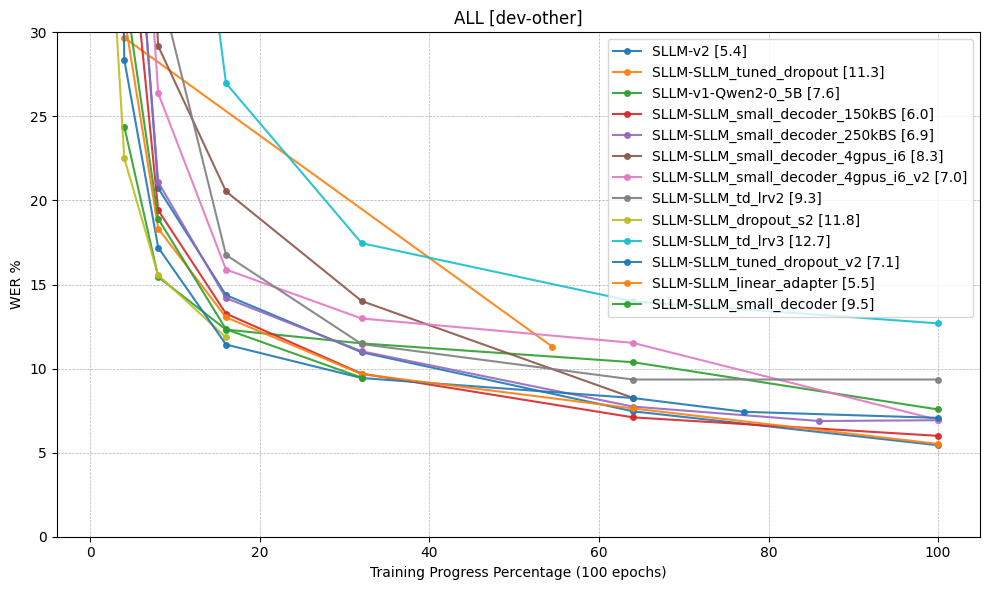

In [33]:
plot_experiments(
    experiments=experiment_results_list,
    title="ALL",
    ylim_max=30,
)

### AED vs SLLM

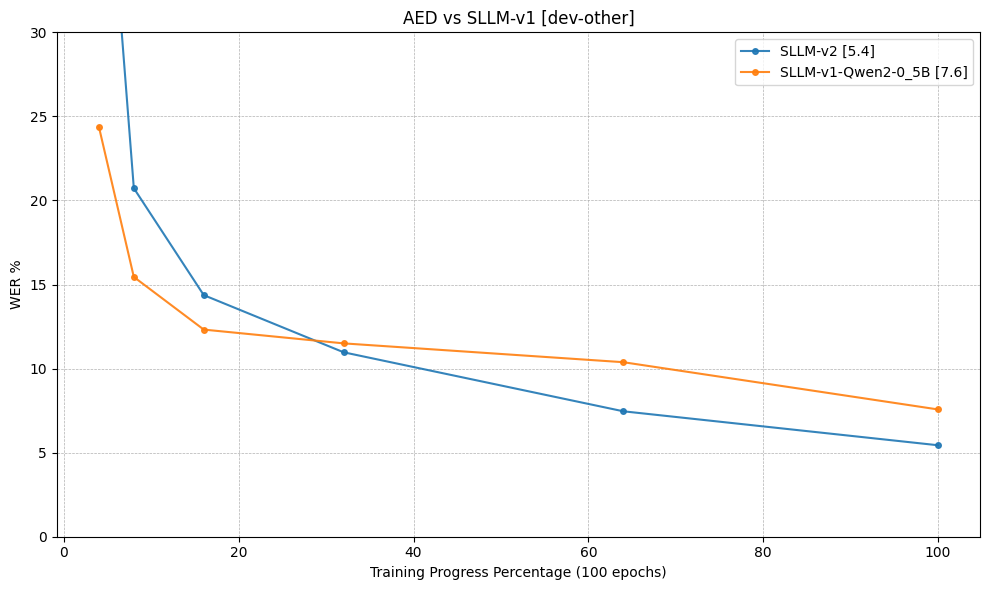

In [34]:
plot_experiments(
    experiments=experiment_results_list,
    include_versions=["v2", "v1-Qwen2-0_5B"],
    title="AED vs SLLM-v1",
)

### Small-decoders

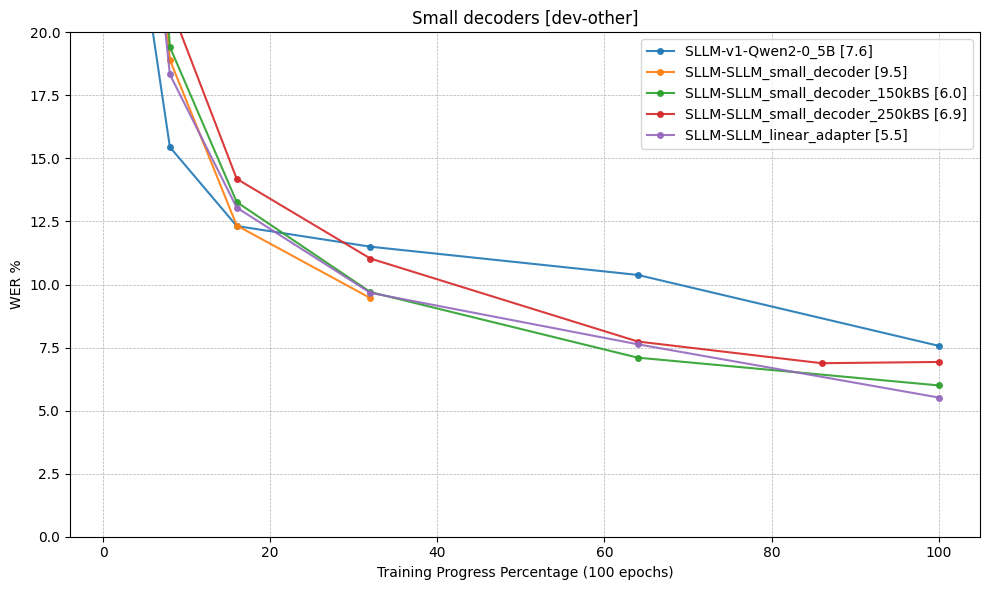

In [35]:
plot_experiments(
    experiments=experiment_results_list,
    include_versions=["v1-Qwen2-0_5B", "SLLM_small_decoder", "SLLM_small_decoder_150kBS", "SLLM_small_decoder_250kBS", "SLLM_linear_adapter"],
    title="Small decoders",
    ylim_max=20,
)

### Base decoders

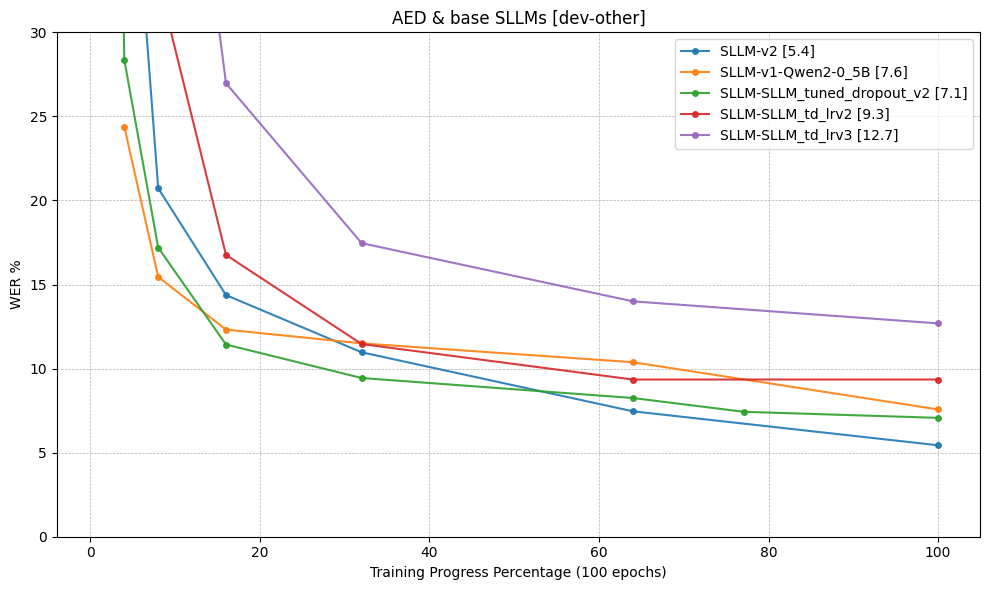

In [36]:
plot_experiments(
    experiments=experiment_results_list,
    include_versions=["v2", "v1-Qwen2-0_5B", "SLLM_tuned_dropout_v2", "SLLM_td_lrv2", "SLLM_td_lrv3"],
    title="AED & base SLLMs",
)

## Best Models [01-01-2025]

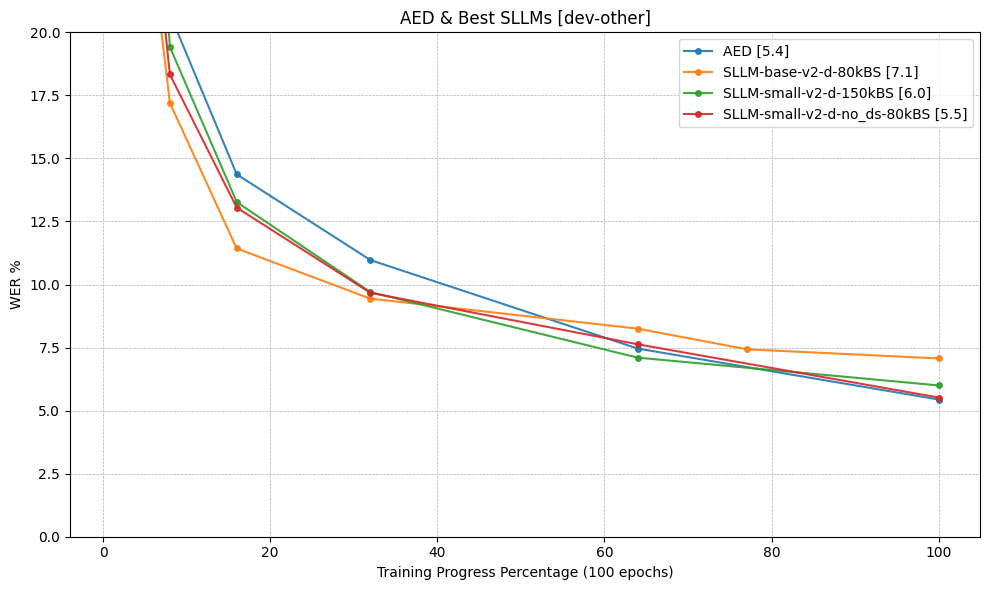

In [37]:
best_models_name_mapping = {
    "v2": "AED",
    "SLLM_tuned_dropout_v2": "SLLM-base-v2-d-80kBS",
    "SLLM_small_decoder_150kBS": "SLLM-small-v2-d-150kBS",
    "SLLM_linear_adapter": "SLLM-small-v2-d-no_ds-80kBS",

}

plot_experiments(
    experiments=experiment_results_list,
    include_versions=["v2", "SLLM_tuned_dropout_v2", "SLLM_small_decoder_150kBS", "SLLM_linear_adapter"],
    title="AED & Best SLLMs",
    ylim_max=20,
    name_mappings=best_models_name_mapping
)

# Tables

In [38]:
import pandas as pd
import numpy as np
import enum

class WerMetric(enum.Enum):
    BEST_OPTION = "best_option" # best4 > best > best epoch

    BEST_WER = "best_wer" # best wer from all checkpoints
    BEST_EPOCH_CKP = "best_epoch" # best wer from epochs

    BEST4_CKP = "best4" # best4 checkpoint
    BEST_CKP = "best" # best checkpoint



def _select_best_wer(entries):
    """
    entries: List[Tuple[str, float]]
    """
    if not entries:
        return np.nan

    # Prefer best4 > best > min
    for tag in ("best4", "best"):
        for k, v in entries:
            if k == tag:
                return v

    return min(v for _, v in entries)


def get_dataset_value(metric: WerMetric, ver: ExperimentVersionResults, ds: str) -> float:
    if metric == WerMetric.BEST_OPTION:
        raise NotImplementedError
    elif metric == WerMetric.BEST_WER:
        return  min(v for _, v in ver.wer_per_epoch_per_eval.get(ds, []) + ver.wer_per_best_per_eval.get(ds, []))
    elif metric == WerMetric.BEST_EPOCH_CKP:
        return min(v for _, v in ver.wer_per_epoch_per_eval.get(ds, []))
    elif metric == WerMetric.BEST4_CKP:
        raise NotImplementedError
    elif metric == WerMetric.BEST_CKP:
        raise NotImplementedError
    else:
        raise NotImplementedError

def create_df(
        experiment_results_list: List[ExperimentResults],
        datasets: Optional[List[str]] = None,
        metric: Optional[WerMetric] = None,
        include_versions: Optional[List[str]] = None,
        exclude_versions: Optional[List[str]] = None,
        num_floating_points: Optional[int] = 1,
) -> pd.DataFrame:

    if datasets is None:
        datasets = ["dev-clean", "dev-other"]
    if metric is None:
        metric = WerMetric.BEST_WER
    if exclude_versions is None:
        exclude_versions = ["v3", "bs15000", "bs30000", "baseline"]

    rows = []

    for exp in experiment_results_list:
        for ver in exp.exp_version_results:
            if not _include_experiment_version(ver.exp_version_name, include_versions, exclude_versions):
                continue

            row = {
                "model": f"{exp.exp_id}",
                "exp": f"{ver.exp_version_name}",
                "max_epoch": f"{ver.get_max_epoch()}/{ver.total_epochs}"
            }

            for ds in datasets:
                val = get_dataset_value(metric, ver, ds)
                row[ds] = round(val, num_floating_points)
            rows.append(row)

    return pd.DataFrame(rows)



In [39]:
results_df = create_df(experiment_results_list, datasets=["dev-clean", "dev-other", "test-clean", "test-other"])
results_df

,model,exp,max_epoch,dev-clean,dev-other,test-clean,test-other
0,AED,v2,500/500,2.2,5.4,2.4,5.6
1,SLLM,SLLM_tuned_dropout,1090/2000,5.0,11.3,5.4,11.7
2,SLLM,v1-Qwen2-0_5B,2000/2000,2.9,7.4,3.0,6.8
3,SLLM,SLLM_small_decoder_150kBS,2000/2000,2.6,6.0,2.9,6.7
4,SLLM,SLLM_small_decoder_250kBS,2000/2000,3.0,6.6,3.1,6.8
5,SLLM,SLLM_small_decoder_4gpus_i6,320/500,4.0,8.3,4.5,8.8
6,SLLM,SLLM_small_decoder_4gpus_i6_v2,500/500,3.8,6.9,3.8,7.1
7,SLLM,v1-Qwen2-0_5B-dropout-15k,640/2000,5.2,12.1,5.5,12.7
8,SLLM,SLLM_td_lrv2,2000/2000,3.6,8.8,3.6,8.8
9,SLLM,SLLM_dropout_s2,320/2000,5.5,11.8,5.3,12.1
